# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

import time

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('DisasterResponse', con=engine)
X = df.loc[:,'message']
y = df.iloc[:,4:]
category_names = y.columns

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text):
    # normalize case and remove punctuation    
    tokenizer = RegexpTokenizer(r'\w+')

    # tokenize text
    token_words = tokenizer.tokenize(text.lower())
    
    # remove stop words
    token_words = [w for w in token_words if w not in stopwords.words('english')]
    
    # extract root form of words
    token_words = [WordNetLemmatizer().lemmatize(word, pos='v') for word in token_words]
    
    return token_words

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [4]:
def build_model():
    
    pipeline = Pipeline([

        ('tfidfV', TfidfVectorizer(tokenizer=tokenize)),

        ('clf', MultiOutputClassifier(
            
            RandomForestClassifier(random_state=42)

        ))

    ])
    
    return pipeline

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [5]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = build_model()

model.fit(X_train, y_train)

end = time.time()
print((end-start)/60, 'minutes')

1.4991851687431335 minutes


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [6]:
def multioutput_classification_report(y_test, y_pred):
    
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
    categories_name = list(y_test.columns)
    
    for i in range(0, len(y_test.columns)):
 
        accuracy_list.append(accuracy_score(y_test.values[:, i], y_pred[:, i]))
        precision_list.append(precision_score(y_test.values[:, i], y_pred[:, i], average='weighted'))
        recall_list.append(recall_score(y_test.values[:, i], y_pred[:, i], average='weighted'))
        f1_list.append(f1_score(y_test.values[:, i], y_pred[:, i], average='weighted'))
    
    df = pd.DataFrame([accuracy_list,precision_list,recall_list,f1_list],
                                columns=categories_name,
                                index=['accuracy_score',
                                       'precision_score',
                                       'recall_score',
                                       'f1_score'])
    df = df.T
    
    return df

In [7]:
# predict
y_pred = model.predict(X_test)

df_clf = multioutput_classification_report(y_test,y_pred)
df_clf.mean()

accuracy_score     0.943961
precision_score    0.933169
recall_score       0.943961
f1_score           0.931697
dtype: float64

## Machine Learning Score Version Control
v0: standard<br>
v1: add stopwords removal<br>
v2: add word lemmatize<br>
v3: remove OneVsRestClassifier<br>

In [8]:
score_v0 = [0.942322, 0.932476, 0.942322, 0.928121]
score_v1 = [0.943629, 0.933004, 0.943629, 0.931176]
score_v2 = [0.943731, 0.932356, 0.943731, 0.931113]
score_v3 = [0.943961, 0.933169, 0.943961, 0.931697]

# index_list = ['accuracy_score','precision_score','recall_score','f1_score']
df_score = pd.DataFrame(list(zip(score_v0, score_v1, score_v2, score_v3)),
                        columns=['v0','v1','v2','v3'],
                        index=['accuracy_score',
                               'precision_score',
                               'recall_score',
                               'f1_score'])
# last version - last but one version
df_score['improvement [%]'] = (df_score.iloc[:,-1]-df_score.iloc[:,-2])*100
df_score

,v0,v1,v2,v3,improvement [%]
accuracy_score,0.942322,0.943629,0.943731,0.943961,0.0230
precision_score,0.932476,0.933004,0.932356,0.933169,0.0813
recall_score,0.942322,0.943629,0.943731,0.943961,0.0230
f1_score,0.928121,0.931176,0.931113,0.931697,0.0584


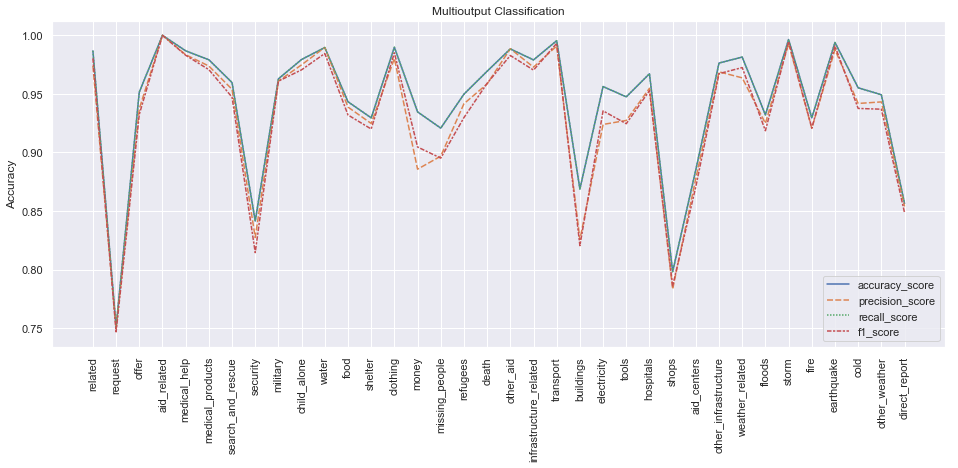

In [10]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(data=df_clf)
g.set_xticklabels(labels = df_clf.index, rotation=90)
plt.title('Multioutput Classification')
plt.ylabel('Accuracy')
plt.show()

### 6. Improve your model
Use grid search to find better parameters. 

In [11]:
def build_model():
    
    pipeline = Pipeline([
        ('tfidfV', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
    ])
    
    parameters = {
        'tfidfV__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__min_samples_split': [2, 4]
    }
    
    cv = GridSearchCV(pipeline, 
                      param_grid=parameters, 
                      verbose=2,
                      n_jobs=-1,
                      cv=3)
    
    return cv

In [12]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = build_model()

model.fit(X_train, y_train)

end = time.time()
print('')
print('Training time')
print((end-start)/60, 'minutes')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.6min finished



Training time
11.208239738146464 minutes


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [13]:
# predict
y_pred = model.predict(X_test)

df_clf = multioutput_classification_report(y_test,y_pred)
df_clf.mean()

accuracy_score     0.942308
precision_score    0.932544
recall_score       0.942308
f1_score           0.929674
dtype: float64

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [14]:
def best_model():
    
    pipeline_ab = Pipeline([
        ('tfidfV', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(
            AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))))
    ]) 
    
    
    pipeline_rf = Pipeline([
        ('tfidfV', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    pipeline_lsvc = Pipeline([
        ('tfidfV', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(
            OneVsRestClassifier(LinearSVC())))
    ])
    
    parameters = {}
    
    # Construct grid searches
    jobs = -1
    
    gs_ab = GridSearchCV(pipeline_ab, 
                         param_grid=parameters,
                         verbose=2,
                         n_jobs=jobs,
                         cv=3)
    
    gs_rf = GridSearchCV(pipeline_rf, 
                         param_grid=parameters,
                         verbose=2,
                         n_jobs=jobs,
                         cv=3)

    gs_lsvc = GridSearchCV(pipeline_lsvc, 
                           param_grid=parameters,
                           verbose=2,
                           n_jobs=jobs,
                           cv=3)
    
    # List of pipelines for ease of iteration
    grids = [gs_ab,gs_rf,gs_lsvc]
    
    # Dictionary of pipelines and classifier types for ease of reference
    grid_dict = {0: 'AdaBoost Classifier',
                 1: 'Random Forest',
                 2: 'Linear Support Vector Classification'}
    
    # Fit the grid search objects
    print('Finding the best model...')
    best_acc = 0.0
    best_clf = 0
    best_gs = ''
    
    for idx, gs in enumerate(grids):
        
        print('\nEstimator: %s' % grid_dict[idx])
        
        # Fit grid search
        gs.fit(X_train, y_train)
        
        # Best params
        print('Best params: %s' % gs.best_params_)
        
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        
        # Predict on test data with best params
        y_pred = gs.predict(X_test)
        
        f1_score = multioutput_classification_report(y_test,y_pred).f1_score.mean()
        
        # Test data accuracy of model with best params
        print('Test f1 score for best params: %.3f ' % f1_score)
        
        # Track best (highest test accuracy) model
        if f1_score > best_acc:
            best_acc = f1_score
            best_gs = gs
            best_clf = idx
            
    print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

    return best_gs

In [15]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

best_model = best_model()

end = time.time()
print('')
print('Training time')
print((end-start)/60, 'minutes')

Finding the best model...

Estimator: AdaBoost Classifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Best params: {}
Best training accuracy: 0.208
Test f1 score for best params: 0.938 

Estimator: Random Forest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Best params: {}
Best training accuracy: 0.237
Test f1 score for best params: 0.930 

Estimator: Linear Support Vector Classification
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Best params: {}
Best training accuracy: 0.269
Test f1 score for best params: 0.943 

Classifier with best test set accuracy: Linear Support Vector Classification

Training time
10.745486513773601 minutes


In [18]:
def build_model():
    
    pipeline = Pipeline([
        ('tfidfV', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(
            OneVsRestClassifier(LinearSVC())))
    ])
    
    parameters = {'tfidfV__ngram_range': ((1, 1), (1, 2)),
                  'tfidfV__max_df':(0.75, 1.0),
                  'clf__estimator__estimator__C':[0.5,1], 
                  'clf__estimator__estimator__max_iter':[100]}
   
    # Construct grid searches
    jobs = -1
    
    gs = GridSearchCV(pipeline, 
                      param_grid=parameters,
                      verbose=2,
                      n_jobs=jobs,
                      cv=3)

    # Dictionary of pipelines and classifier types for ease of reference
    grid_dict = {0: 'Linear Support Vector Classification'}
    
    # Fit the grid search objects
    print('Performing model optimizations...')
    
    print('\nEstimator: %s' % grid_dict[0])
    
    gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    
    f1_score = multioutput_classification_report(y_test,y_pred).f1_score.mean()    
    
    # Test data accuracy of model with best params
    print('Test f1 score for best params: %.3f ' % f1_score)

    return gs

In [19]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

best_model_param = build_model()

end = time.time()
print('')
print('Training time')
print((end-start)/60, 'minutes')

Performing model optimizations...

Estimator: Linear Support Vector Classification
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 11.0min finished


Best params: {'clf__estimator__estimator__C': 0.5, 'clf__estimator__estimator__max_iter': 100, 'tfidfV__max_df': 0.75, 'tfidfV__ngram_range': (1, 1)}
Best training accuracy: 0.281
Test f1 score for best params: 0.943 

Training time
12.12506830294927 minutes


### 9. Export your model as a pickle file

In [20]:
# Save best grid search pipeline to file
dump_file = 'best_model.pkl'
joblib.dump(best_model_param.best_estimator_, dump_file, compress=1)
print('\nSaved grid search pipeline to file: %s' % (dump_file))


Saved grid search pipeline to file: best_model.pkl


### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.